In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb

from matplotlib import pyplot as plt

In [4]:
csv_file = 'HeartDiseaseLarge.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True) # shuffle all rows and reset index

df.drop(columns = ['eid'],inplace=True) # Drop the eid
n_patients = len(df.index) # Number of all patients

In [5]:
target = df.pop('HeartDisease') # OUTPUT
features = df

In [6]:
TEST_SIZE = 0.2 # train size = 0.8
# split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=1)

In [23]:
# xgboost train/test split with no tuning
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")
xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

train AUC score: 0.9766113134824743
test AUC score: 0.6697001439623926


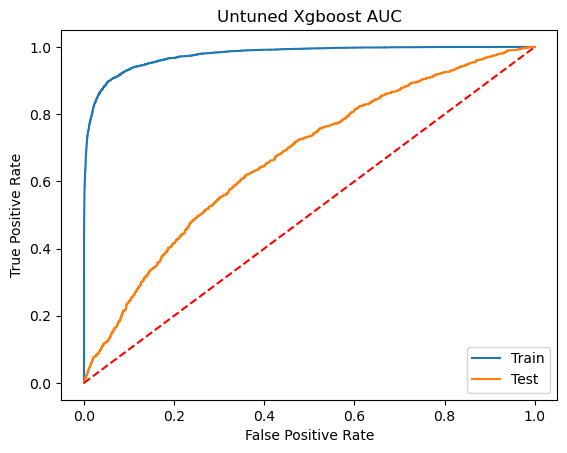

In [24]:
y_predict_train = xgb_cl.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, y_predict_train[:,1])  # traindataset
plt.plot(fpr, tpr)
y_predict = xgb_cl.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Untuned Xgboost AUC')
plt.legend(['Train', 'Test'])
print(f'train AUC score: {roc_auc_score(y_train, y_predict_train[:,1])}')
print(f'test AUC score: {roc_auc_score(y_test, y_predict[:,1])}')

In [25]:
# randomized search params
params = {'max_depth': [1, 3, 5, 6, 10, 15, 20],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.3, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000, 1500]}

In [26]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")
rand_cv = RandomizedSearchCV(xgb_cl, params, n_iter=25, scoring="roc_auc", verbose=1)
rand_cv.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           predictor=None, random_state=None, ...),
                   n_iter=25,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [1, 3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000, 1500],
                                        'subsample': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='roc_auc', verbose=1)

In [27]:
# best fit parameters
rand_cv.best_params_

{'subsample': 0.4,
 'n_estimators': 1000,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.7999999999999999}

In [28]:
# get best model from randomized search
xgb_tuned = rand_cv.best_estimator_

train AUC score: 0.7548794573472335
test AUC score: 0.7148524631526958


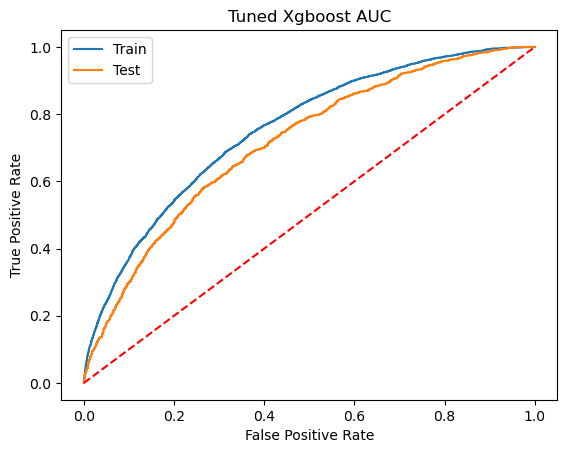

In [29]:
# roc & auc score for train and test sets with tuned xgboost model
y_predict_train = xgb_tuned.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, y_predict_train[:,1])  # traindataset
plt.plot(fpr, tpr)
y_predict = xgb_tuned.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Xgboost AUC')
plt.legend(['Train', 'Test'])
print(f'train AUC score: {roc_auc_score(y_train, y_predict_train[:,1])}')
print(f'test AUC score: {roc_auc_score(y_test, y_predict[:,1])}')

In [42]:
# test data shapley values
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(x_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


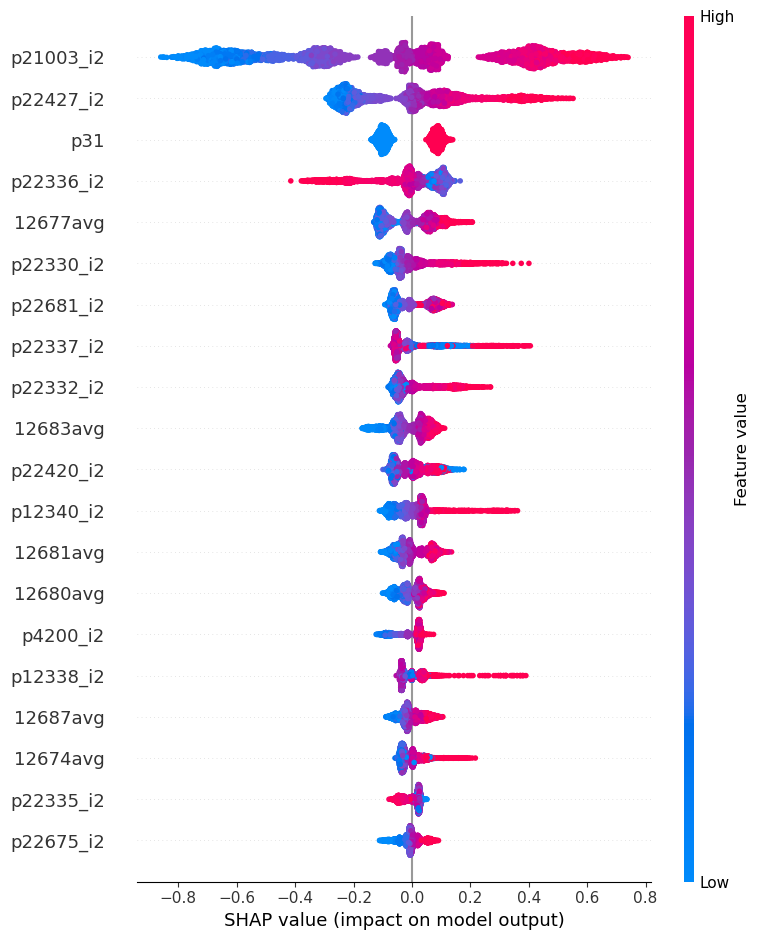

In [32]:
shap.summary_plot(shap_values, x_test)

In [ ]:
# top 5 features: Age, body surface area, sex, T axis (ECG), PQ interval (ECG)

In [53]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values)

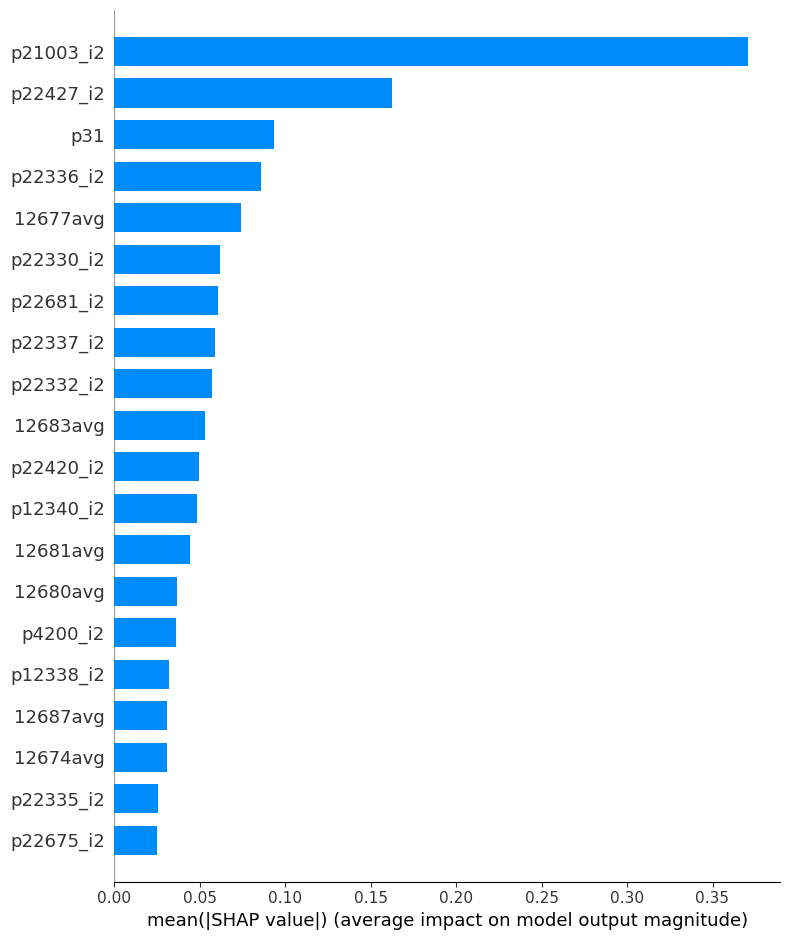

In [56]:
shap.summary_plot(shap_values, x_test, plot_type='bar')